[<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/pytorch/rl/blob/main/tutorials/coding_dqn.ipynb)

# Coding a pixel-based DQN using TorchRL

This tutorial will guide you through the steps to code DQN to solve the CartPole task from scratch.
DQN ([Deep Q-Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)) was the founding work in deep reinforcement learning. On a high level, the algorithm is quite simple: Q-learning consists in learning a table of state-action values in such a way that, when facing any particular state, we know which action to pick just by searching for the action with the highest value. This simple setting requires the actions and states to be discretizable. DQN uses a neural network that maps state-actions pairs to a certain value, which amortizes the cost of storing and exploring all the possible states: if a state has not been seen in the past, we can still pass it through our neural network and get an interpolated value for each of the actions available.

In this tutorial, you will learn:
- how to build an environment in TorchRL, including transforms (e.g. data normalization, frame concatenation, resizing and turning to grayscale) and parallel execution;
- how to design a QValue actor, i.e. an actor that esitmates the action values and picks up the action with the highest estimated return;
- how to collect data from your environment efficiently and store them in a replay buffer;
- how to store trajectories (and not transitions) in your replay buffer), and how to estimate returns using TD(lambda);
- how to make a module *functional* and use ;
- and finally how to evaluate your model.

This tutorial assumes the reader is familiar with some of TorchRL primitives, such as `TensorDict` and `TensorDictModules`, although it should be sufficiently transparent to be understood without a deep understanding of these classes.

We do not aim at giving a SOTA implementation of the algorithm, but rather to provide a high-level illustration of TorchRL features in the context of this algorithm.

In [1]:
!pip install torchrl-nightly
!pip install imageio
!pip install tqdm
!pip install matplotlib
!pip install "gym[classic_control]"

In [2]:
import torch
import tqdm
from IPython import display
from matplotlib import pyplot as plt
from torch import nn

from torchrl.collectors import MultiaSyncDataCollector
from torchrl.data import TensorDict, TensorDictReplayBuffer, LazyMemmapStorage
from torchrl.envs import ParallelEnv, EnvCreator
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.transforms import TransformedEnv, ToTensorImage, Compose, \
    GrayScale, CatFrames, ObservationNorm, Resize, CatTensors
from torchrl.envs.utils import set_exploration_mode
from torchrl.envs.utils import step_mdp
from torchrl.modules import QValueActor, EGreedyWrapper, DuelingCnnDQNet


def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import imageio
from IPython.display import Video


/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

Let's start with our hyperparameters. This is a totally arbitrary list of hyperparams that we found to work well in practice. Hopefully the performance of the algorithm should not be too sentitive to slight variations of these.

In [3]:
# hyperparams

# the learning rate of the optimizer
lr = 2e-3
# the beta parameters of Adam
betas = (0.9, 0.999)
# gamma decay factor
gamma = 0.99
# lambda decay factor (see second the part with TD(lambda) 
lmbda = 0.95
# total frames collected in the environment. In other implementations, the user defines a maximum number of episodes. 
# This is harder to do with our data collectors since they return batches of N collected frames, where N is a constant.
# However, one can easily get the same restriction on number of episodes by breaking the training loop when a certain number 
# episodes has been collected.
total_frames = 500000
# Random frames used to initialize the replay buffer.
init_random_frames = 500
# Frames in each batch collected.
frames_per_batch = 256
# Optimization steps per batch collected
n_optim = 4
# Frames sampled from the replay buffer at each optimization step
batch_size = 256
# Size of the replay buffer in terms of frames
buffer_size = 100000
# Number of environments run in parallel in each data collector
n_workers = 2

device = "cuda:0" if torch.cuda.device_count() > 0 else "cpu"

# Smooth target network update decay parameter. This loosely corresponds to a 1/(1-tau) interval with hard target network update
tau = 0.005

# Initial and final value of the epsilon factor in Epsilon-greedy exploration (notice that since our policy is deterministic exploration is crucial)
eps_greedy_val = 0.1
eps_greedy_val_env = 0.05

# To speed up learning, we set the bias of the last layer of our value network to a predefined value
init_bias = 20.0


## Building the environment

Our environment builder has three arguments:
- parallel: determines whether multiple environments have to be run in parallel. We stack the transforms after the ParallelEnv to take advantage of vectorization of the operations on device, although this would techinally work with every single environment attached to its own set of transforms.
- mean and standard deviation: we normalize the observations (images) with two parameters computed from a random rollout in the environment.

In [4]:
def make_env(parallel=False, m=0, s=1):
    
    if parallel:
        base_env = ParallelEnv(
            n_workers, 
            EnvCreator(lambda: GymEnv("CartPole-v1", from_pixels=True, pixels_only=True, device=device))
        )
    else:
        base_env = GymEnv("CartPole-v1", from_pixels=True, pixels_only=True, device=device)
    
    env = TransformedEnv(
        base_env, 
        Compose(
            ToTensorImage(), 
            GrayScale(),
            Resize(64, 64),
            ObservationNorm(keys_in=["next_pixels"], loc=m, scale=s, standard_normal=True),
            CatFrames(4, keys_in=["next_pixels"]),
        ))
    return env


Compute normalizing constants:

In [5]:
dummy_env = make_env()
v = dummy_env.transform[3].parent.reset()["pixels"]
m, s = v.mean().item(), v.std().item()
m, s

/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/torchrl/envs/libs/gym.py:319: UserWarning: Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
  warn(


(0.9927797317504883, 0.07610216736793518)

## The problem

We can have a look at the problem by generating a video with a random policy. From gym:
> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

In [6]:
# we add a CatTensors transform to copy the "next_pixels" before it's being replaced by its grayscale, resized version
dummy_env.transform.insert(0, CatTensors(["next_pixels"], "next_pixels_save", del_keys=False))
# we omit the policy from the rollout call: this will generate random actions from the env.action_spec attribute
eval_rollout = dummy_env.rollout(max_steps=10000).cpu()

imageio.mimwrite('cartpole_random.mp4', eval_rollout["next_pixels_save"].numpy(), fps=30); 
Video('cartpole_random.mp4', width=480, height=360)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x674f5c0] Warning: data is not aligned! This can lead to a speed loss


## Building the model (Deep Q-network)

The following function builds a [`DuelingCnnDQNet`](https://arxiv.org/abs/1511.06581) object which is a simple CNN followed by a two-layer MLP. The only trick used here is that the action values (i.e. left and right action value) are computed using

```
values = baseline(observation) + values(observation) - values(observation).mean()
```

where `baseline` is a `num_obs -> 1` function and `values` is a `num_obs -> num_actions` function.

Our network is wrapped in a `QValueActor`, which will read the state-action values, pick up the one with the maximum value and write all those results in the input `TensorDict`.

In [7]:
def make_model():
    cnn_kwargs = {
    "num_cells": [32, 64, 64], 
        "kernel_sizes": [6, 4, 3], 
        "strides": [2, 2, 1], 
        "activation_class": nn.ELU, 
        "squeeze_output": True, 
        "aggregator_class": nn.AdaptiveAvgPool2d, 
        "aggregator_kwargs": {"output_size": (1, 1)}
    }
    mlp_kwargs = {
        "depth": 2,
        "num_cells": [64, 64, ], 
        # "out_features": dummy_env.action_spec.shape[-1], 
        "activation_class": nn.ELU
    }
    net = DuelingCnnDQNet(dummy_env.action_spec.shape[-1], 1, cnn_kwargs, mlp_kwargs).to(device)
    net.value[-1].bias.data.fill_(init_bias)


    actor = QValueActor(net, in_keys=["pixels"], spec=dummy_env.action_spec).to(device)
    # init actor
    tensordict = dummy_env.reset()
    print("reset results:", tensordict)
    actor(tensordict)
    print("Q-value network results:", tensordict)
    
    # make functional
    factor, (_, buffers) = actor.make_functional_with_buffers(clone=True, native=True)
    # making functional creates a copy of the params, which we don't want (i.e. we want the parameters from `actor` to match those in the params object),
    # hence we create the params object in a second step
    params = TensorDict({k: v for k, v in net.named_parameters()}, []).unflatten_keys(".")
    
    # creating the target parameters is fairly easy with tensordict:
    params_target, buffers_target = params.to_tensordict().detach(), buffers.to_tensordict().detach()

    # we wrap our actor in an EGreedyWrapper for data collection
    actor_explore = EGreedyWrapper(actor, annealing_num_steps=total_frames, eps_init=eps_greedy_val, eps_end=eps_greedy_val_env)

    return factor, actor, actor_explore, params, buffers, params_target, buffers_target


When creating the model, we initialize the network with an environment reset. We print the resulting tensordict instance to get an idea of what `QValueActor` (pay attention to the keys `action`, `action_value` and `chosen_action_value` after calling the policy)

In [8]:
factor, actor, actor_explore, params, buffers, params_target, buffers_target = make_model()
params_flat = params.flatten_keys(".")
buffers_flat = buffers.flatten_keys(".")
params_target_flat = params_target.flatten_keys(".")
buffers_target_flat = buffers_target.flatten_keys(".")

/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


reset results: TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([4, 64, 64]), dtype=torch.float32),
        pixels_save: Tensor(torch.Size([400, 600, 3]), dtype=torch.uint8)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Q-value network results: TensorDict(
    fields={
        action: Tensor(torch.Size([2]), dtype=torch.int64),
        action_value: Tensor(torch.Size([2]), dtype=torch.float32),
        chosen_action_value: Tensor(torch.Size([1]), dtype=torch.float32),
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([4, 64, 64]), dtype=torch.float32),
        pixels_save: Tensor(torch.Size([400, 600, 3]), dtype=torch.uint8)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)


## Regular DQN

We'll start with a simple implementation of DQN where the returns are computed without bootstrapping, i.e. 
```
return = reward + gamma * value_next_step * not_terminated
```

We start with the *replay buffer*.
We'll use a regular replay buffer, although a prioritized RB could improve the performance significantly. We place the storage on disk using `LazyMemmapStorage`. The only requirement of this storage is that the data given to it must always have the same shape.
This storage will be instantiated later.

In [9]:
replay_buffer = TensorDictReplayBuffer(
    buffer_size, 
    storage=LazyMemmapStorage(buffer_size), 
    collate_fn=lambda x: x,
    prefetch=n_optim,
)

Our *data collector* will run two parallel environments in parallel, and deliver the collected tensordicts once at a time to the main process. We'll use the `MultiaSyncDataCollector` collector, which will collect data while the optimization is taking place.

In [ ]:

data_collector = MultiaSyncDataCollector(
    [make_env(True, m=m, s=s), make_env(True, m=m, s=s)],  # 2 collectors, each with an set of `num_workers` environments being run in parallel
    policy=actor_explore,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    exploration_mode="random",  # this is the default behaviour: the collector runs in `"random"` (or explorative) mode
    devices=[device, device],  # each collector can sit on a different device
    passing_devices=[device, device],
)


Our *optimizer* and the env used for evaluation

In [11]:
optim = torch.optim.Adam(list(params_flat.values()), lr)
dummy_env = make_env(parallel=False, m=m, s=s)
print(actor_explore(dummy_env.reset()))

TensorDict(
    fields={
        action: Tensor(torch.Size([2]), dtype=torch.int64),
        action_value: Tensor(torch.Size([2]), dtype=torch.float32),
        chosen_action_value: Tensor(torch.Size([1]), dtype=torch.float32),
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([4, 64, 64]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)


/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/torchrl/envs/libs/gym.py:319: UserWarning: Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
  warn(


Various lists that will contain the values recorded for evaluation

In [12]:
evals = []
traj_lengths_eval = []
losses = []
frames = []
values = []
grad_vals = []
traj_lengths = []
mavgs = []
traj_count = []
prev_traj_count = 0

### Training loop

In [13]:
pbar = tqdm.tqdm(total=total_frames)
for j, data in enumerate(data_collector):
    # trajectories are padded to be stored in the same tensordict: since we do not care about consecutive step, we'll just mask the tensordict and get the flattened representation instead.
    mask = data["mask"].squeeze(-1)
    current_frames = mask.sum().cpu().item()
    pbar.update(current_frames)

    # We store the values on the replay buffer, after placing them on CPU. When called for the first time, this will instantiate our storage object which will print its content.
    replay_buffer.extend(data[mask].cpu())
    
    # some logging
    if len(frames):
        frames.append(current_frames + frames[-1])
    else:
        frames.append(current_frames)
    
    if data["done"].any():
        traj_lengths.append(data["step_count"][data["done"]].float().mean().item())
    
    # check that we have enough data to start training
    if sum(frames) > init_random_frames:
        for i in range(n_optim):
            # sample from the RB and send to device
            sampled_data = replay_buffer.sample(batch_size).to(device, non_blocking=True)

            # collect data from RB
            reward = sampled_data["reward"].squeeze(-1)
            done = sampled_data["done"].squeeze(-1).to(reward.dtype)
            action = sampled_data["action"].clone()

            # Compute action value (of the action actually taken) at time t
            sampled_data_out = sampled_data.select(*actor.in_keys)
            sampled_data_out = factor(sampled_data_out, params=params, buffers=buffers)
            action_value = sampled_data_out["action_value"]
            action_value = (action_value * action.to(action_value.dtype)).sum(-1)
            with torch.no_grad():
                # compute best action value for the next step, using target parameters
                tdstep = step_mdp(sampled_data)
                next_value = factor(
                    tdstep.select(*actor.in_keys), 
                    params=params_target, 
                    buffers=buffers_target
                )["chosen_action_value"].squeeze(-1)
                exp_value = reward + gamma * next_value * (1 - done)
            assert exp_value.shape == action_value.shape
            # we use MSE loss but L1 or smooth L1 should also work
            error = nn.functional.mse_loss(exp_value, action_value).mean()
            error.backward()
            
            gv = sum([p.grad.pow(2).sum() for p in params_flat.values()]).sqrt()
            nn.utils.clip_grad_value_(list(params_flat.values()), 1)

            optim.step()
            optim.zero_grad()

            # update of the target parameters
            for (key, p1) in params_flat.items():
                p2 = params_target_flat[key]
                params_target_flat.set_(key, tau * p1.data + (1-tau) * p2.data)
            for (key, p1) in buffers_flat.items():
                p2 = buffers_target_flat[key]
                buffers_target_flat.set_(key, tau * p1.data + (1-tau) * p2.data)

        pbar.set_description(f"error: {error: 4.4f}, value: {action_value.mean(): 4.4f}")
        actor_explore.step(current_frames)
    
        # logs
        with set_exploration_mode("mode"), torch.no_grad():
            # execute a rollout. The `set_exploration_mode("mode")` has no effect here since the policy is deterministic, but we add it for completeness
            eval_rollout = dummy_env.rollout(max_steps=10000, policy=actor).cpu()
        grad_vals.append(float(gv))
        traj_lengths_eval.append(eval_rollout.shape[-1])
        evals.append(eval_rollout["reward"].squeeze(-1).sum(-1).item())
        if len(mavgs):
            mavgs.append(evals[-1]*0.05 + mavgs[-1]*0.95)
        else:
            mavgs.append(evals[-1])
        losses.append(error.item())
        values.append(action_value.mean().item())
        traj_count.append(prev_traj_count + data["done"].sum().item())
        prev_traj_count = traj_count[-1]
        # plots
        if j % 100 == 0:
            if is_notebook():
                display.clear_output(wait=True)
                display.display(plt.gcf())
            else:
                plt.clf()
            plt.figure(figsize=(15, 15))
            plt.subplot(3,2,1)
            plt.plot(frames[-len(evals):], evals, label="return")
            plt.plot(frames[-len(mavgs):], mavgs, label="mavg")
            plt.xlabel("frames collected")
            plt.ylabel("trajectory length (= return)")
            plt.subplot(3,2,2)
            plt.plot(traj_count[-len(evals):], evals, label="return")
            plt.plot(traj_count[-len(mavgs):], mavgs, label="mavg")
            plt.xlabel("trajectories collected")
            plt.legend()
            plt.subplot(3,2,3)
            plt.plot(frames[-len(losses):], losses)
            plt.xlabel("frames collected")
            plt.title("loss")
            plt.subplot(3,2,4)
            plt.plot(frames[-len(values):], values)
            plt.xlabel("frames collected")
            plt.title("value")
            plt.subplot(3,2,5)
            plt.plot(frames[-len(grad_vals):], grad_vals)
            plt.xlabel("frames collected")
            plt.title("grad norm")
            plt.savefig("dqn_td0.png")
            if len(traj_lengths):
                plt.subplot(3,2,6)
                plt.plot(traj_lengths)
                plt.xlabel("batches")
                plt.title("traj length (training)")
            if is_notebook():
                plt.show()
    
    # update policy weights
    data_collector.update_policy_weights_()

if is_notebook():
    display.clear_output(wait=True)
    display.display(plt.gcf())

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

(-0.5, 1499.5, 1499.5, -0.5)

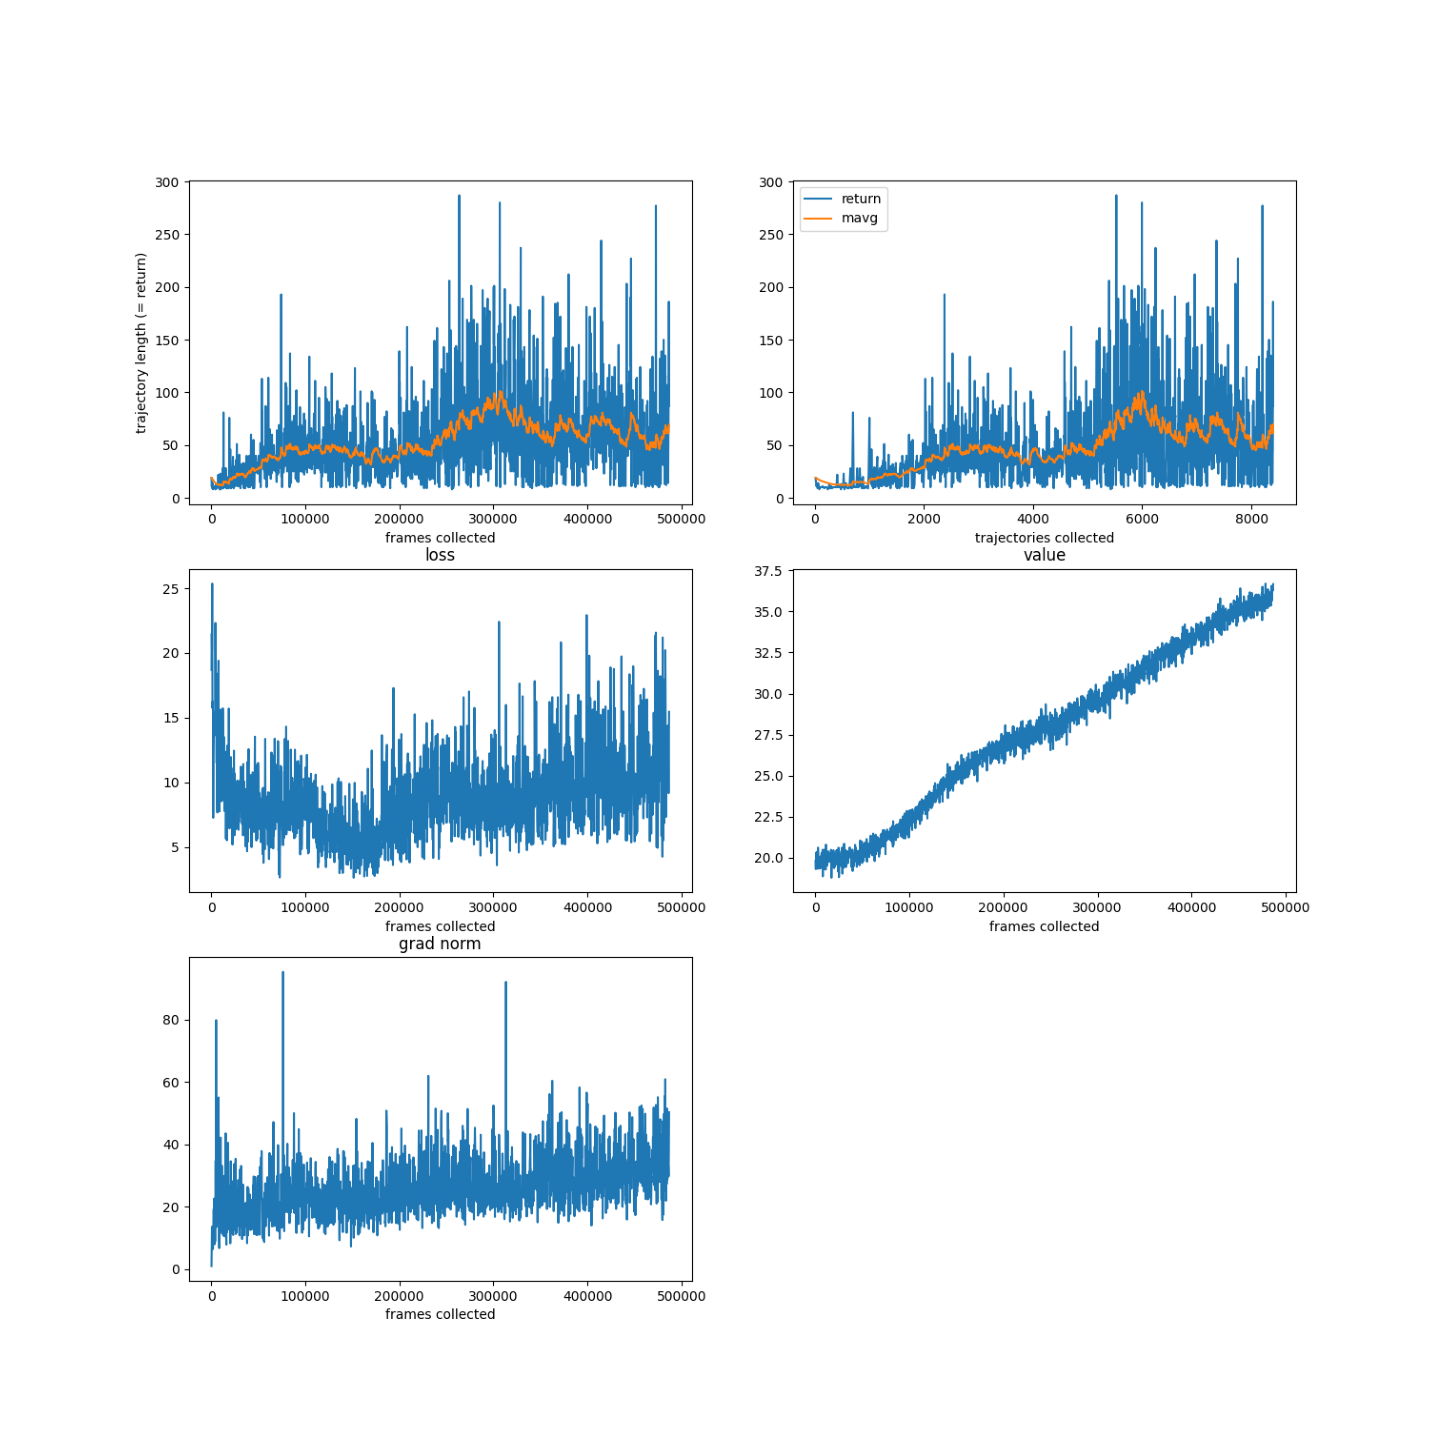

In [14]:
plt.figure(figsize=(15, 15))
plt.imshow(plt.imread("dqn_td0.png"))
plt.tight_layout()
plt.axis('off')

In [27]:
# save results
torch.save({
    "frames": frames,
    "evals": evals,
    "mavgs": mavgs,
    "losses": losses,
    "values": values,
    "grad_vals": grad_vals,
    "traj_lengths_training": traj_lengths,
    "traj_count": traj_count,
    "weights": (params, buffers),
}, "saved_results_td0.pt")




error:  8.0940, value:  45.1970: : 500224it [33:59, 131.00it/s]Process Process-4:1:
Process Process-3:1:
Process Process-4:2:
Process Process-3:2:
Traceback (most recent call last):
  File "/fsx/users/vmoens/conda/envs/rl/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/fsx/users/vmoens/conda/envs/rl/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/torchrl/envs/vec_env.py", line 933, in _run_worker_pipe_shared_mem
    cmd, data = child_pipe.recv()
  File "/fsx/users/vmoens/conda/envs/rl/lib/python3.9/multiprocessing/connection.py", line 255, in recv
    buf = self._recv_bytes()
  File "/fsx/users/vmoens/conda/envs/rl/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/fsx/users/vmoens/conda/envs/rl/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chu

## TD-lambda

We can improve the above algorithm by getting a better estimate of the return, using not only the next state value but the whole sequence of rewards and values that follow a particular step.

TorchRL provides a vectorized version of TD(lambda) named `vec_td_lambda_advantage_estimate`. We'll use this to obtain a target value that the value network will be trained to match.

The big difference in this implementation is that we'll store entire trajectories and not single steps in the replay buffer. This will be done automatically as long as we're not "flattening" the tensordict collected using its mask: by keeping a shape `[Batch x timesteps]` and giving this to the RB, we'll be creating a replay buffer of size `[Capacity x timesteps]`.

In [16]:
from torchrl.data.tensordict.tensordict import pad
from torchrl.objectives.value.functional import vec_td_lambda_advantage_estimate

We reset the actor, the RB and the collector

In [17]:
factor, actor, actor_explore, params, buffers, params_target, buffers_target = make_model()
params_flat = params.flatten_keys(".")
buffers_flat = buffers.flatten_keys(".")
params_target_flat = params_target.flatten_keys(".")
buffers_target_flat = buffers_target.flatten_keys(".")

reset results: TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([4, 64, 64]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Q-value network results: TensorDict(
    fields={
        action: Tensor(torch.Size([2]), dtype=torch.int64),
        action_value: Tensor(torch.Size([2]), dtype=torch.float32),
        chosen_action_value: Tensor(torch.Size([1]), dtype=torch.float32),
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([4, 64, 64]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)


/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
max_size = frames_per_batch // n_workers

replay_buffer = TensorDictReplayBuffer(
    -(-buffer_size // max_size), 
    storage=LazyMemmapStorage(buffer_size), 
    collate_fn=lambda x: x,
    prefetch=n_optim,
)

data_collector = MultiaSyncDataCollector(
    [make_env(True, m=m, s=s), make_env(True, m=m, s=s)],
    policy=actor_explore,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    exploration_mode="random",
    devices=[device, device],
    passing_devices=[device, device],
)


In [19]:
optim = torch.optim.Adam(list(params_flat.values()), lr)
dummy_env = make_env(parallel=False, m=m, s=s)
print(actor_explore(dummy_env.reset()))


TensorDict(
    fields={
        action: Tensor(torch.Size([2]), dtype=torch.int64),
        action_value: Tensor(torch.Size([2]), dtype=torch.float32),
        chosen_action_value: Tensor(torch.Size([1]), dtype=torch.float32),
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([4, 64, 64]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)


/fsx/users/vmoens/conda/envs/rl/lib/python3.9/site-packages/torchrl/envs/libs/gym.py:319: UserWarning: Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
  warn(


In [20]:
evals = []
traj_lengths_eval = []
losses = []
frames = []
values = []
grad_vals = []
traj_lengths = []
mavgs = []
traj_count = []
prev_traj_count = 0

### Training loop

There are very few differences with the training loop above:
- The tensordict received by the collector is not masked but padded to the desired shape (such that all tensordicts have the same shape of `[Batch x max_size]`), and sent directly to the RB.
- We use `vec_td_lambda_advantage_estimate` to compute the target value.

In [21]:
pbar = tqdm.tqdm(total=total_frames)
for j, data in enumerate(data_collector):
    mask = data["mask"].squeeze(-1)
    data = pad(data, [0, 0, 0, max_size-data.shape[1]])
    current_frames = mask.sum().cpu().item()
    pbar.update(current_frames)

    replay_buffer.extend(data.cpu())
    if len(frames):
        frames.append(current_frames + frames[-1])
    else:
        frames.append(current_frames)
    
    if data["done"].any():
        traj_lengths.append(data["step_count"][data["done"]].float().mean().item())
    
    if sum(frames) > init_random_frames:
        for i in range(n_optim):
            sampled_data = replay_buffer.sample(batch_size // max_size).to(device, non_blocking=True)

            reward = sampled_data["reward"]
            done = sampled_data["done"].to(reward.dtype)
            action = sampled_data["action"].clone()

            sampled_data_out = sampled_data.select(*actor.in_keys)
            sampled_data_out = factor(sampled_data_out, params=params, buffers=buffers, vmap=(None, None, 0))
            action_value = sampled_data_out["action_value"]
            action_value = (action_value * action.to(action_value.dtype)).sum(-1, True)
            with torch.no_grad():
                tdstep = step_mdp(sampled_data)
                next_value = factor(
                    tdstep.select(*actor.in_keys), 
                    params=params_target, 
                    buffers=buffers_target,
                    vmap=(None, None, 0),
                )["chosen_action_value"]
            error = vec_td_lambda_advantage_estimate(
                gamma,
                lmbda,
                action_value,
                next_value,
                reward,
                done,
            ).pow(2)
            # reward + gamma * next_value * (1 - done)
            mask = sampled_data["mask"]
            error = error[mask].mean()
            # assert exp_value.shape == action_value.shape
            # error = nn.functional.smooth_l1_loss(exp_value, action_value).mean()
            # error = nn.functional.mse_loss(exp_value, action_value)[mask].mean()
            error.backward()
            
            # gv = sum([p.grad.pow(2).sum() for p in params_flat.values()]).sqrt()
            # nn.utils.clip_grad_value_(list(params_flat.values()), 1)
            gv = nn.utils.clip_grad_norm_(list(params_flat.values()), 100)

            optim.step()
            optim.zero_grad()

            for (key, p1) in params_flat.items():
                p2 = params_target_flat[key]
                params_target_flat.set_(key, tau * p1.data + (1-tau) * p2.data)
            for (key, p1) in buffers_flat.items():
                p2 = buffers_target_flat[key]
                buffers_target_flat.set_(key, tau * p1.data + (1-tau) * p2.data)

        pbar.set_description(f"error: {error: 4.4f}, value: {action_value.mean(): 4.4f}")
        actor_explore.step(current_frames)
    
        # logs
        with set_exploration_mode("random"), torch.no_grad():
    #         eval_rollout = dummy_env.rollout(max_steps=1000, policy=actor_explore, auto_reset=True).cpu()
            eval_rollout = dummy_env.rollout(max_steps=10000, policy=actor, auto_reset=True).cpu()
        grad_vals.append(float(gv))
        traj_lengths_eval.append(eval_rollout.shape[-1])
        evals.append(eval_rollout["reward"].squeeze(-1).sum(-1).item())
        if len(mavgs):
            mavgs.append(evals[-1]*0.05 + mavgs[-1]*0.95)
        else:
            mavgs.append(evals[-1])
        losses.append(error.item())
        values.append(action_value[mask].mean().item())
        traj_count.append(prev_traj_count + data["done"].sum().item())
        prev_traj_count = traj_count[-1]
        # plots
        if j % 100 == 0:
            if is_notebook():
                display.clear_output(wait=True)
                display.display(plt.gcf())
            else:
                plt.clf()
            plt.figure(figsize=(15, 15))
            plt.subplot(3,2,1)
            plt.plot(frames[-len(evals):], evals, label="return")
            plt.plot(frames[-len(mavgs):], mavgs, label="mavg")
            plt.xlabel("frames collected")
            plt.ylabel("trajectory length (= return)")
            plt.subplot(3,2,2)
            plt.plot(traj_count[-len(evals):], evals, label="return")
            plt.plot(traj_count[-len(mavgs):], mavgs, label="mavg")
            plt.xlabel("trajectories collected")
            plt.legend()
            plt.subplot(3,2,3)
            plt.plot(frames[-len(losses):], losses)
            plt.xlabel("frames collected")
            plt.title("loss")
            plt.subplot(3,2,4)
            plt.plot(frames[-len(values):], values)
            plt.xlabel("frames collected")
            plt.title("value")
            plt.subplot(3,2,5)
            plt.plot(frames[-len(grad_vals):], grad_vals)
            plt.xlabel("frames collected")
            plt.title("grad norm")
            if len(traj_lengths):
                plt.subplot(3,2,6)
                plt.plot(traj_lengths)
                plt.xlabel("batches")
                plt.title("traj length (training)")
            plt.savefig("dqn_tdlambda.png")
            if is_notebook():
                plt.show()
    
    # update policy weights
    data_collector.update_policy_weights_()

if is_notebook():
    display.clear_output(wait=True)
    display.display(plt.gcf())

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

(-0.5, 1499.5, 1499.5, -0.5)

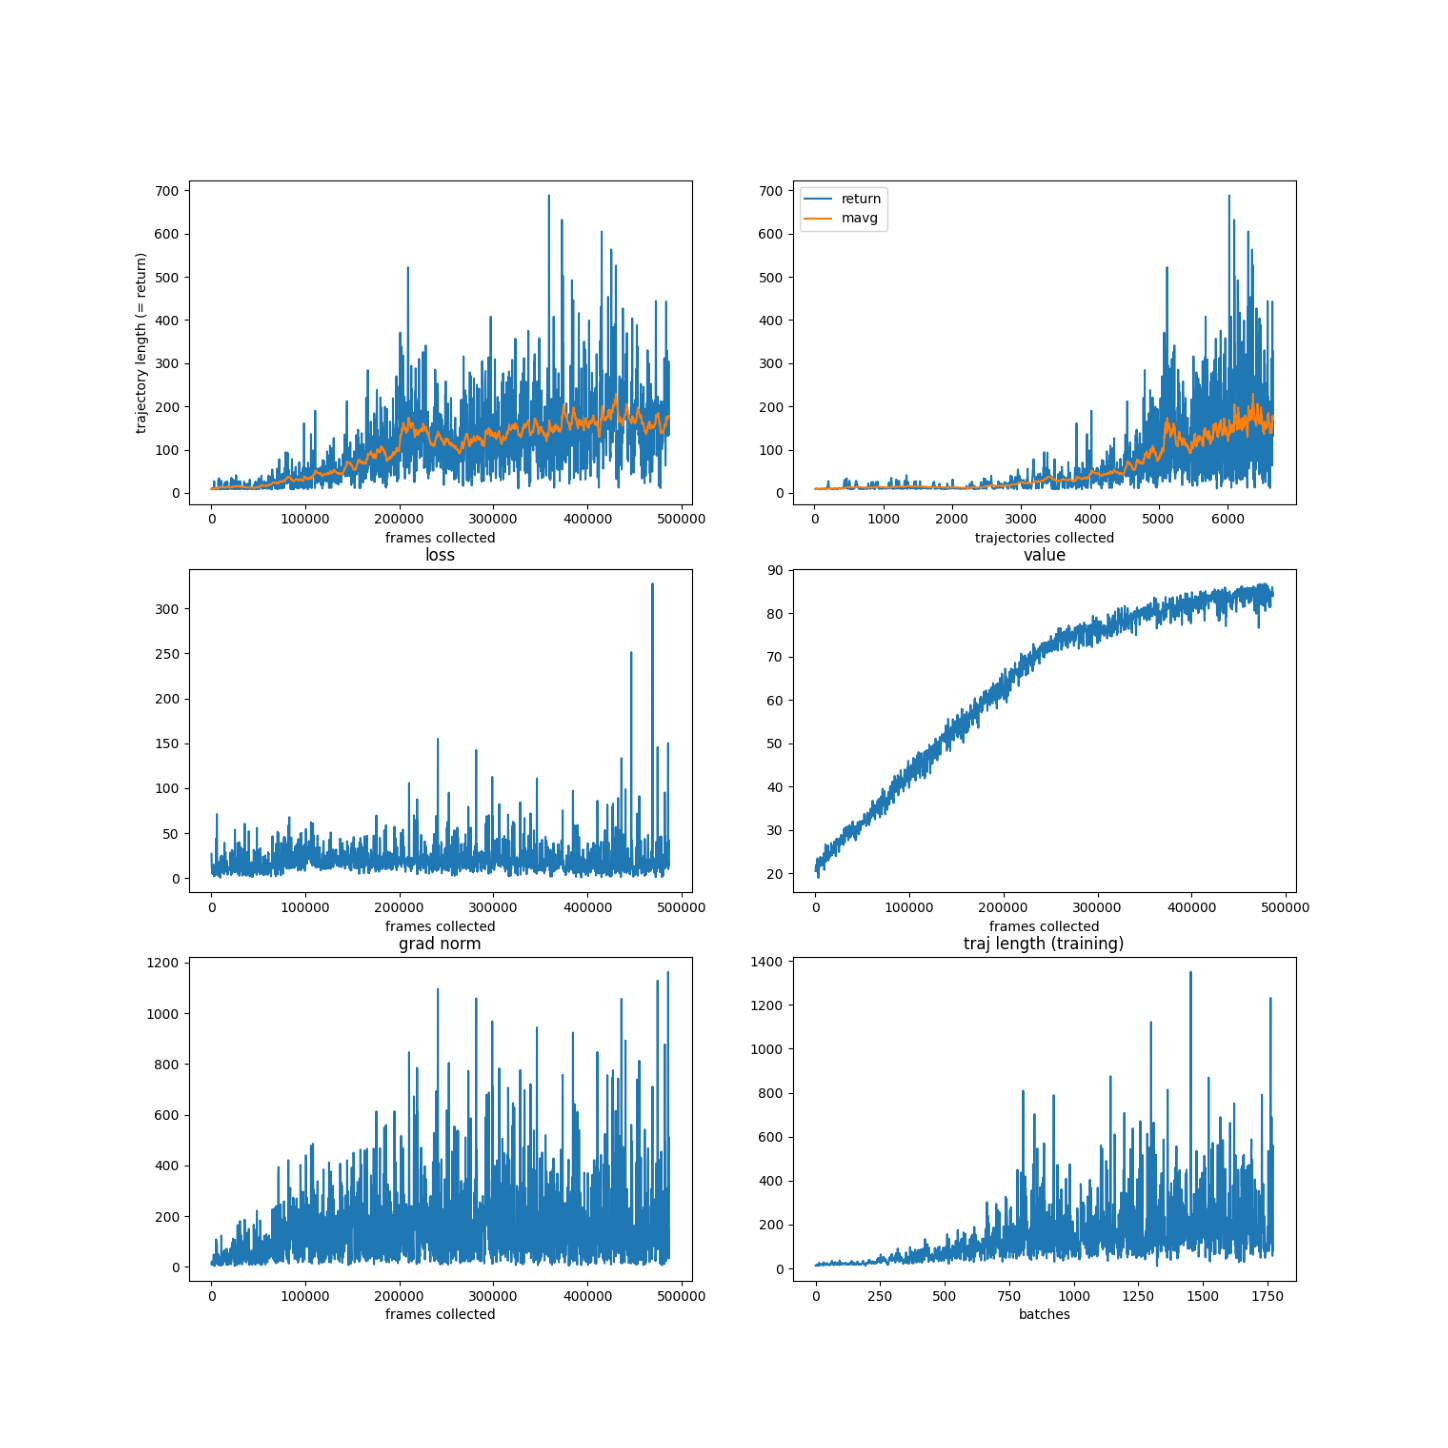

In [22]:
plt.figure(figsize=(15, 15))
plt.imshow(plt.imread("dqn_tdlambda.png"))
plt.tight_layout()
plt.axis('off')

In [23]:
# save results
torch.save({
    "frames": frames,
    "evals": evals,
    "mavgs": mavgs,
    "losses": losses,
    "values": values,
    "grad_vals": grad_vals,
    "traj_lengths_training": traj_lengths,
    "traj_count": traj_count,
    "weights": (params, buffers),
}, "saved_results_tdlambda.pt")


Let's compare the results on a single plot.
Because the TD(lambda) version works better, we'll have fewer episodes collected for a given number of frames (as there are more frames per episode).

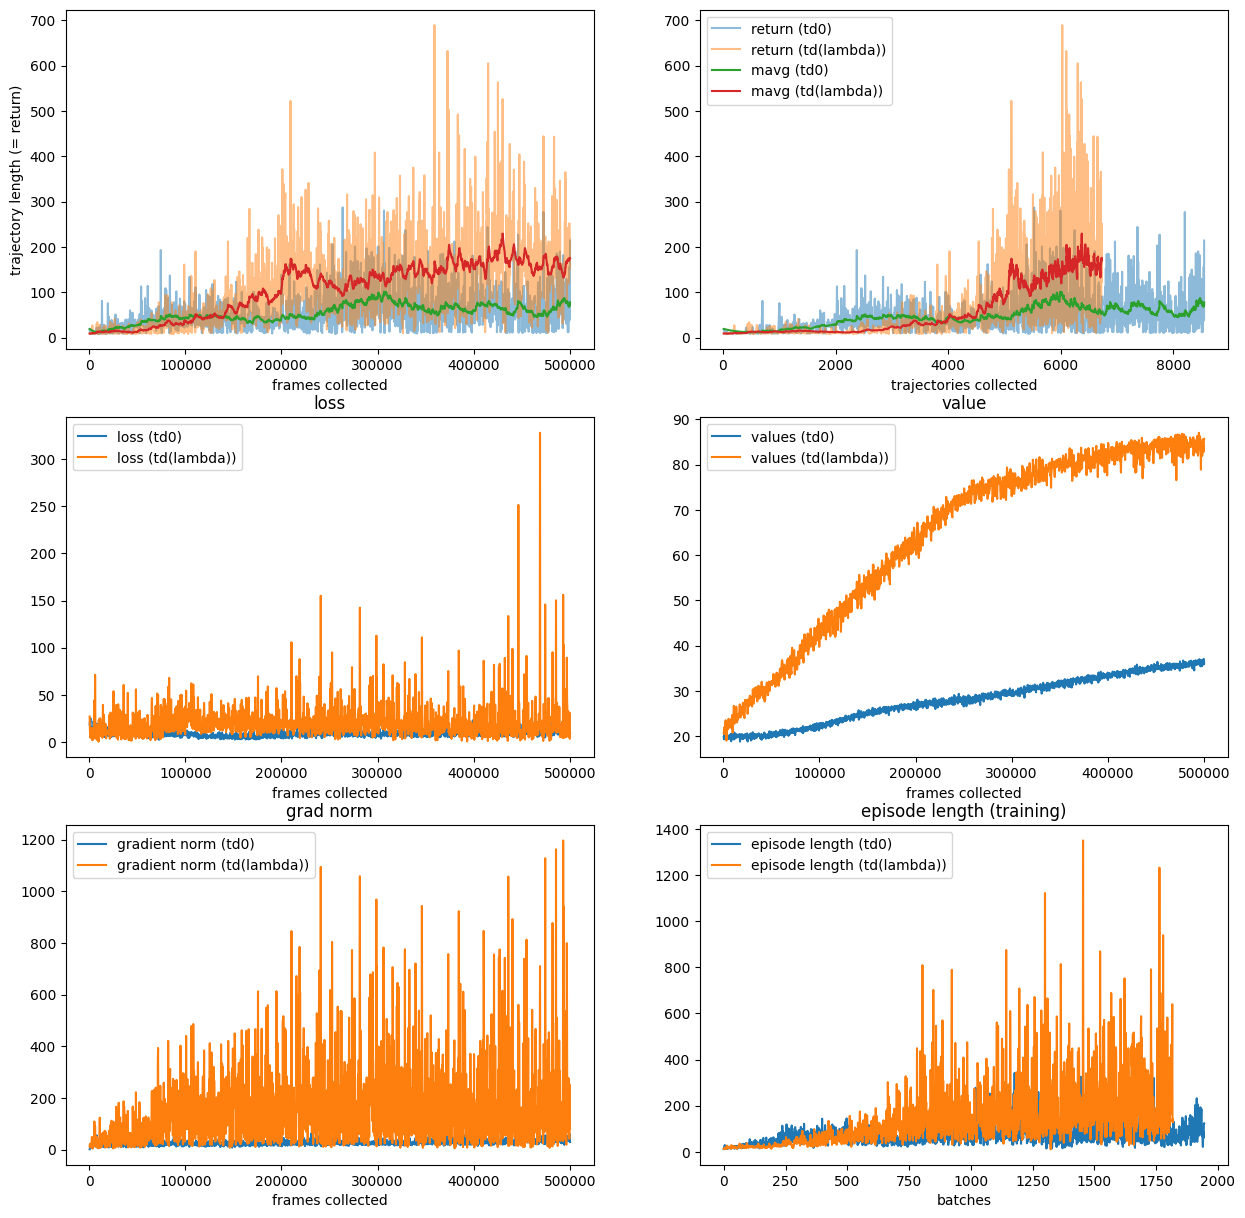

In [24]:
load_td0 = torch.load("saved_results_td0.pt")
load_tdlambda = torch.load("saved_results_tdlambda.pt")
frames_td0 = load_td0["frames"]
frames_tdlambda = load_tdlambda["frames"]
evals_td0 = load_td0["evals"]
evals_tdlambda = load_tdlambda["evals"]
mavgs_td0 = load_td0["mavgs"]
mavgs_tdlambda = load_tdlambda["mavgs"]
losses_td0 = load_td0["losses"]
losses_tdlambda = load_tdlambda["losses"]
values_td0 = load_td0["values"]
values_tdlambda = load_tdlambda["values"]
grad_vals_td0 = load_td0["grad_vals"]
grad_vals_tdlambda = load_tdlambda["grad_vals"]
traj_lengths_td0 = load_td0["traj_lengths_training"]
traj_lengths_tdlambda = load_tdlambda["traj_lengths_training"]
traj_count_td0 = load_td0["traj_count"]
traj_count_tdlambda = load_tdlambda["traj_count"]

plt.figure(figsize=(15, 15))
plt.subplot(3,2,1)
plt.plot(frames[-len(evals_td0):], evals_td0, label="return (td0)", alpha=0.5)
plt.plot(frames[-len(evals_tdlambda):], evals_tdlambda, label="return (td(lambda))", alpha=0.5)
plt.plot(frames[-len(mavgs_td0):], mavgs_td0, label="mavg (td0)")
plt.plot(frames[-len(mavgs_tdlambda):], mavgs_tdlambda, label="mavg (td(lambda))")
plt.xlabel("frames collected")
plt.ylabel("trajectory length (= return)")
plt.subplot(3,2,2)
plt.plot(traj_count_td0[-len(evals_td0):], evals_td0, label="return (td0)", alpha=0.5)
plt.plot(traj_count_tdlambda[-len(evals_tdlambda):], evals_tdlambda, label="return (td(lambda))", alpha=0.5)
plt.plot(traj_count_td0[-len(mavgs_td0):], mavgs_td0, label="mavg (td0)")
plt.plot(traj_count_tdlambda[-len(mavgs_tdlambda):], mavgs_tdlambda, label="mavg (td(lambda))")
plt.xlabel("trajectories collected")
plt.legend()
plt.subplot(3,2,3)
plt.plot(frames[-len(losses_td0):], losses_td0, label="loss (td0)")
plt.plot(frames[-len(losses_tdlambda):], losses_tdlambda, label="loss (td(lambda))")
plt.xlabel("frames collected")
plt.title("loss")
plt.legend()
plt.subplot(3,2,4)
plt.plot(frames[-len(values_td0):], values_td0, label="values (td0)")
plt.plot(frames[-len(values_tdlambda):], values_tdlambda, label="values (td(lambda))")
plt.xlabel("frames collected")
plt.title("value")
plt.legend()
plt.subplot(3,2,5)
plt.plot(frames[-len(grad_vals_td0):], grad_vals_td0, label="gradient norm (td0)")
plt.plot(frames[-len(grad_vals_tdlambda):], grad_vals_tdlambda, label="gradient norm (td(lambda))")
plt.xlabel("frames collected")
plt.title("grad norm")
plt.legend()
if len(traj_lengths):
    plt.subplot(3,2,6)
    plt.plot(traj_lengths_td0, label="episode length (td0)")
    plt.plot(traj_lengths_tdlambda, label="episode length (td(lambda))")
    plt.xlabel("batches")
    plt.legend()
    plt.title("episode length (training)")


Finally, we generate a new video to check what the algorithm has learnt. If all goes well, the duration should be significantly longer than with the initial, random rollout.

In [25]:
dummy_env.transform.insert(0, CatTensors(["next_pixels"], "next_pixels_save", del_keys=False))
eval_rollout = dummy_env.rollout(max_steps=10000, policy=actor, auto_reset=True).cpu()
eval_rollout

TensorDict(
    fields={
        action: Tensor(torch.Size([113, 2]), dtype=torch.int64),
        action_value: Tensor(torch.Size([113, 2]), dtype=torch.float32),
        chosen_action_value: Tensor(torch.Size([113, 1]), dtype=torch.float32),
        done: Tensor(torch.Size([113, 1]), dtype=torch.bool),
        next_pixels: Tensor(torch.Size([113, 4, 64, 64]), dtype=torch.float32),
        next_pixels_save: Tensor(torch.Size([113, 400, 600, 3]), dtype=torch.uint8),
        pixels: Tensor(torch.Size([113, 4, 64, 64]), dtype=torch.float32),
        pixels_save: Tensor(torch.Size([113, 400, 600, 3]), dtype=torch.uint8),
        reward: Tensor(torch.Size([113, 1]), dtype=torch.float32)},
    batch_size=torch.Size([113]),
    device=cpu,
    is_shared=False)

In [26]:
import imageio; 
from IPython.display import Video; 
imageio.mimwrite('cartpole.mp4', eval_rollout["next_pixels_save"].numpy(), fps=30); 
Video('cartpole.mp4', width=480, height=360) #the width and height option as additional thing new in Ipython 7.6.1

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x648c5c0] Warning: data is not aligned! This can lead to a speed loss


## Conclusion and possible improvements

We have seen that using TD(lambda) greatly improved the performance of our algorithm.
Other possible improvements could include:
- using the Multi-Step post-processing. Multi-step will project an action to the nth following step, and create a discounted sum of the rewards in between. This trick can make the algorithm noticebly less myopic. To use this, simply create the collector with
    
    ```python
    from torchrl.data.postprocs.postprocs import MultiStep
    collector = CollectorClass(..., postproc=MultiStep(gamma, n))
    ```
    
    where `n` is the number of looking-forward steps.
    Pay attention to the fact that the `gamma` factor has to be corrected by the number of steps till the next observation when being passed to vec_td_lambda_advantage_estimate:
    
    ```python
    gamma = gamma ** tensordict["steps_to_next_obs"]
    ```
- A prioritized replay buffer could also be used. This will give a higher priority to samples that have the worst value accuracy.
- A distributional loss (see `torchrl.objectives.DistributionalDQNLoss` for more information).
- More fancy exploration techniques, such as NoisyLinear layers and such (check `torchrl.modules.NoisyLinear`, which is fully compatible with the `MLP` class used in our Dueling DQN).